# Preparing the sample data set

## About the Iris dataset
For the following tutorial, we will be working with the famous “Iris” dataset that has been deposited on the UCI machine learning repository
(https://archive.ics.uci.edu/ml/datasets/Iris).

**Reference:** Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.
The iris dataset contains measurements for 150 iris flowers from three different species.

The three classes in the Iris dataset:

Iris-setosa (n=50)
Iris-versicolor (n=50)
Iris-virginica (n=50)
The four features of the Iris dataset:

sepal length in cm
sepal width in cm
petal length in cm
petal width in cm

In [2]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

## Reading in the dataset

In [3]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


### Since it is more convenient to work with numerical values, we will use the LabelEncode from the scikit-learn library to convert the class labels into numbers: 1, 2, and 3.

In [3]:
from sklearn.preprocessing import LabelEncoder

X = df[[0,1,2,3]].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

NameError: name 'df' is not defined

## Histograms and feature selection
### Just to get a rough idea how the samples of our three classes ω1, ω2 and ω3 are distributed, let us visualize the distributions of the four different features in 1-dimensional histograms.

In [7]:
%matplotlib inline

NameError: name 'X' is not defined

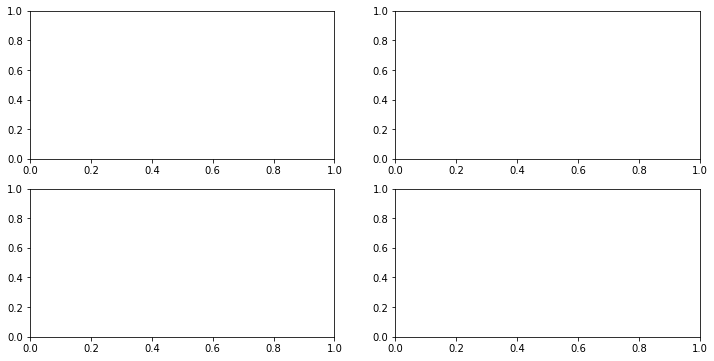

In [8]:
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

## LDA in 5 steps
## After we went through several preparation steps, our data is finally ready for the actual LDA. In practice, LDA for dimensionality reduction would be just another preprocessing step for a typical machine learning or pattern classification task.


Step 1: Computing the d-dimensional mean vectors
In this first step, we will start off with a simple computation of the mean vectors mmi, (i=1,2,3) of the 3 different flower classes:

mmi=⎡⎣⎢⎢⎢⎢⎢μωi(sepal length)μωi(sepal width)μωi(petal length)μωi(petal width)⎤⎦⎥⎥⎥⎥⎥,withi=1,2,3

In [9]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

NameError: name 'X' is not defined

Mean Vector class 1: [ 5.006  3.418  1.464  0.244]

Mean Vector class 2: [ 5.936  2.77   4.26   1.326]

Mean Vector class 3: [ 6.588  2.974  5.552  2.026]

Step 2: Computing the Scatter Matrices
Now, we will compute the two 4x4-dimensional matrices: The within-class and the between-class scatter matrix.

2.1 Within-class scatter matrix SW
The within-class scatter matrix SW is computed by the following equation:

SW=∑i=1cSi
where
Si=∑xx∈Din(xx−mmi)(xx−mmi)T
(scatter matrix for every class)

and mmi is the mean vector
mmi=1ni∑xx∈Dinxxk

In [ ]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

2.1 b
Alternatively, we could also compute the class-covariance matrices by adding the scaling factor 1N−1 to the within-class scatter matrix, so that our equation becomes

Σi=1Ni−1∑xx∈Din(xx−mmi)(xx−mmi)T.

and SW=∑i=1c(Ni−1)Σi
where Ni is the sample size of the respective class (here: 50), and in this particular case, we can drop the term (Ni−1) since all classes have the same sample size.

However, the resulting eigenspaces will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor).

2.2 Between-class scatter matrix SB
The between-class scatter matrix SB is computed by the following equation:

SB=∑i=1cNi(mmi−mm)(mmi−mm)T
where
mm is the overall mean, and mmi and Ni are the sample mean and sizes of the respective classes.

In [4]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

NameError: name 'X' is not defined

## Step 3: Solving the generalized eigenvalue problem for the matrix S−1WSB
### Next, we will solve the generalized eigenvalue problem for the matrix S−1WSB to obtain the linear discriminants.

In [ ]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))

Note

Depending on which version of NumPy and LAPACK we are using, we may obtain the matrix W with its signs flipped. Please note that this is not an issue; if v is an eigenvector of a matrix Σ, we have

Σv=λv.

Here, λ is the eigenvalue, and v is also an eigenvector that thas the same eigenvalue, since

Sigma(−v)=−−vΣ=−λv=λ(−v).

After this decomposition of our square matrix into eigenvectors and eigenvalues, let us briefly recapitulate how we can interpret those results. As we remember from our first linear algebra class in high school or college, both eigenvectors and eigenvalues are providing us with information about the distortion of a linear transformation: The eigenvectors are basically the direction of this distortion, and the eigenvalues are the scaling factor for the eigenvectors that describing the magnitude of the distortion.

If we are performing the LDA for dimensionality reduction, the eigenvectors are important since they will form the new axes of our new feature subspace; the associated eigenvalues are of particular interest since they will tell us how “informative” the new “axes” are.

Let us briefly double-check our calculation and talk more about the eigenvalues in the next section.

Checking the eigenvector-eigenvalue calculation
A quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:

AAvv=λvv
where
AA=S^(−1)WSB
vv=Eigenvector
λ=Eigenvalue

In [5]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
print('ok')

NameError: name 'eig_vals' is not defined

## Step 4: Selecting linear discriminants for the new feature subspace
### 4.1. Sorting the eigenvectors by decreasing eigenvalues
Remember from the introduction that we are not only interested in merely projecting the data into a subspace that improves the class separability, but also reduces the dimensionality of our feature space, (where the eigenvectors will form the axes of this new feature subspace).

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.
The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top k eigenvectors.

In [6]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

NameError: name 'eig_vals' is not defined

## Note

If we take a look at the eigenvalues, we can already see that 2 eigenvalues are close to 0. The reason why these are close to 0 is not that they are not informative but it’s due to floating-point imprecision. In fact, these two last eigenvalues should be exactly zero: In LDA, the number of linear discriminants is at most c−1 where c is the number of class labels, since the in-between scatter matrix SB is the sum of c matrices with rank 1 or less. Note that in the rare case of perfect collinearity (all aligned sample points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue.

Now, let’s express the “explained variance” as percentage:

In [7]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:



NameError: name 'eig_vals' is not defined

## The first eigenpair is by far the most informative one, and we won’t loose much information if we would form a 1D-feature spaced based on this eigenpair.

### 4.2. Choosing k eigenvectors with the largest eigenvalues
After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our k×d-dimensional eigenvector matrix WW (here 4×2: based on the 2 most informative eigenpairs) and thereby reducing the initial 4-dimensional feature space into a 2-dimensional feature subspace.

In [ ]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

## Step 5: Transforming the samples onto the new subspace
### In the last step, we use the 4×2-dimensional matrix WW that we just computed to transform our samples onto the new subspace via the equation

YY=XX×WW.

(where XX is a n×d-dimensional matrix representing the n samples, and YY are the transformed n×k-dimensional samples in the new subspace).

In [9]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

NameError: name 'X' is not defined

NameError: name 'X_lda' is not defined

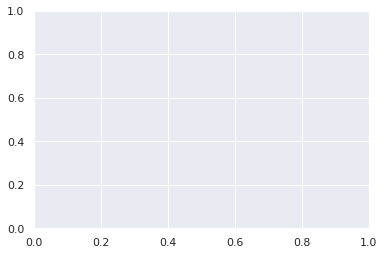

In [8]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

The scatter plot above represents our new feature subspace that we constructed via LDA. We can see that the first linear discriminant “LD1” separates the classes quite nicely. However, the second discriminant, “LD2”, does not add much valuable information, which we’ve already concluded when we looked at the ranked eigenvalues is step 4.

## A comparison of PCA and LDA
In order to compare the feature subspace that we obtained via the Linear Discriminant Analysis, we will use the PCA class from the scikit-learn machine-learning library. The documentation can be found here:
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

For our convenience, we can directly specify to how many components we want to retain in our input dataset via the n_components parameter.

In [10]:
n_components : int, None or string

Number of components to keep. if n_components is not set all components are kept:
    n_components == min(n_samples, n_features)
    if n_components == ‘mle’, Minka’s MLE is used to guess the dimension if 0 < n_components < 1,
    select the number of components such that the amount of variance that needs to be explained
    is greater than the percentage specified by n_components

SyntaxError: invalid syntax (<ipython-input-10-b24daba3d221>, line 1)

But before we skip to the results of the respective linear transformations, let us quickly recapitulate the purposes of PCA and LDA: PCA finds the axes with maximum variance for the whole data set where LDA tries to find the axes for best class seperability. In practice, often a LDA is done followed by a PCA for dimensionality reduction.

In [ ]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
X_pca = sklearn_pca.fit_transform(X)

def plot_pca():

    ax = plt.subplot(111)

    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('PC1')
    plt.ylabel('PC2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Iris projection onto the first 2 principal components')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.tight_layout
    plt.grid()

    plt.show()

In [ ]:
plot_pca()
plot_step_lda()

The two plots above nicely confirm what we have discussed before: Where the PCA accounts for the most variance in the whole dataset, the LDA gives us the axes that account for the most variance between the individual classes.

## LDA via scikit-learn
Now, after we have seen how an Linear Discriminant Analysis works using a step-by-step approach, there is also a more convenient way to achive the same via the LDA class implemented in the scikit-learn machine learning library.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X, y)

In [ ]:
def plot_scikit_lda(X, title):

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label] * -1, # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title)

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

In [ ]:
plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')

## A Note About Standardization
To follow up on a question that I received recently, I wanted to clarify that feature scaling such as [standardization] does not change the overall results of an LDA and thus may be optional. Yes, the scatter matrices will be different depending on whether the features were scaled or not. In addition, the eigenvectors will be different as well. However, the important part is that the eigenvalues will be exactly the same as well as the final projects – the only difference you’ll notice is the scaling of the component axes. This can be shown mathematically (I will insert the formulaes some time in future), and below is a practical, visual example for demonstration.

In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
df[4] = df[4].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
df.tail()

After loading the dataset, we are going to standardize the columns in X. Standardization implies mean centering and scaling to unit variance:

xstd=x−μxσX
After standardization, the columns will have zero mean ( μxstd=0 ) and a standard deviation of 1 (σxstd=1).

In [ ]:
y, X = df.iloc[:, 4].values, df.iloc[:, 0:4].values
X_cent = X - X.mean(axis=0)
X_std = X_cent / X.std(axis=0)

Below, I simply copied the individual steps of an LDA, which we discussed previously, into Python functions for convenience.

In [ ]:
import numpy as np

def comp_mean_vectors(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    mean_vectors = []
    for cl in class_labels:
        mean_vectors.append(np.mean(X[y==cl], axis=0))
    return mean_vectors

def scatter_within(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)
    S_W = np.zeros((n_features, n_features))
    for cl, mv in zip(class_labels, mean_vectors):
        class_sc_mat = np.zeros((n_features, n_features))                 
        for row in X[y == cl]:
            row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1)
            class_sc_mat += (row-mv).dot((row-mv).T)
        S_W += class_sc_mat                           
    return S_W

def scatter_between(X, y):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)    
    S_B = np.zeros((n_features, n_features))
    for i, mean_vec in enumerate(mean_vectors):  
        n = X[y==i+1,:].shape[0]
        mean_vec = mean_vec.reshape(n_features, 1)
        overall_mean = overall_mean.reshape(n_features, 1)
        S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return S_B

def get_components(eig_vals, eig_vecs, n_comp=2):
    n_features = X.shape[1]
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    W = np.hstack([eig_pairs[i][1].reshape(4, 1) for i in range(0, n_comp)])
    return W

First, we are going to print the eigenvalues, eigenvectors, transformation matrix of the un-scaled data:

In [ ]:
S_W, S_B = scatter_within(X, y), scatter_between(X, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W)

In [ ]:
X_lda = X.dot(W)
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_lda[y==label, 0], X_lda[y==label, 1],
                color=color, marker=marker)

Next, we are repeating this process for the standarized flower dataset:

In [ ]:
S_W, S_B = scatter_within(X_std, y), scatter_between(X_std, y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W_std = get_components(eig_vals, eig_vecs, n_comp=2)
print('EigVals: %s\n\nEigVecs: %s' % (eig_vals, eig_vecs))
print('\nW: %s' % W_std)

In [ ]:
X_std_lda = X_std.dot(W_std)
X_std_lda[:, 1] = X_std_lda[:, 1]
for label,marker,color in zip(
        np.unique(y),('^', 's', 'o'),('blue', 'red', 'green')):
    plt.scatter(X_std_lda[y==label, 0], X_std_lda[y==label, 1],
                color=color, marker=marker)

### As we can see, the eigenvalues are excactly the same whether we scaled our data or not (note that since W has a rank of 2, the two lowest eigenvalues in this 4-dimensional dataset should effectively be 0). Furthermore, we see that the projections look identical except for the different scaling of the component axes and that it is mirrored in this case.